In [6]:
def calculate_mixed_states_free_energy(configurations, half_box, r0=1.2):
    """
    Calculate the free energy difference between mixed states (2A1B vs 1A2B).
    
    Args:
        configurations (numpy.ndarray): Particle configurations with shape (n_samples, n_particles, dimensions)
        half_box (float): Half the box size for boundary calculations
        r0 (float): Particle radius parameter for well classification
        
    Returns:
        float: Free energy difference between the 2A1B and 1A2B states in kB*T units
    """
    # Get classifications for all configurations
    classifications = classify_particles(configurations, half_box, r0)
    
    # Count configurations in each relevant state
    count_2A1B = 0  # AAB state
    count_1A2B = 0  # ABB state
    
    for config_class in classifications:
        num_A = np.sum(config_class == 'A')
        num_B = np.sum(config_class == 'B')
        num_outside = np.sum(config_class == 'Outside')
        
        # Only count configurations where all particles are in wells A or B
        if num_outside == 0:
            if num_A == 2 and num_B == 1:
                count_2A1B += 1
            elif num_A == 1 and num_B == 2:
                count_1A2B += 1
    
    # Calculate free energy difference if both states have non-zero counts
    if count_2A1B > 0 and count_1A2B > 0:
        deltaF = -np.log(count_2A1B / count_1A2B)  # Negative sign because we want ΔF_ABB-AAB
        print(f"Number of 2A1B configurations: {count_2A1B}")
        print(f"Number of 1A2B configurations: {count_1A2B}")
        print(f"Free energy difference (1A2B - 2A1B): {deltaF:.4f} kB*T")
    else:
        if count_2A1B == 0:
            print("No configurations found with 2 particles in well A and 1 in well B.")
        if count_1A2B == 0:
            print("No configurations found with 1 particle in well A and 2 in well B.")
        deltaF = None
    
    return deltaF, count_2A1B, count_1A2B

In [ ]:
def analyze_and_plot_mixed_states(configurations, half_box, r0=1.2, directory=None, base_filename="mixed_states_stats"):
    """
    Analyze and plot statistics for the mixed states (2A1B and 1A2B) over time.
    
    Args:
        configurations (numpy.ndarray): Particle configurations with shape (n_samples, n_particles, dimensions)
        half_box (float): Half the box size for boundary calculations
        r0 (float): Particle radius parameter for well classification
        directory (str): Directory to save the plots
        base_filename (str): Base filename for saved plots
        
    Returns:
        tuple: Paths to the saved plots (svg, png)
    """
    # Get classifications for all configurations
    classifications = classify_particles(configurations, half_box, r0)
    
    count_2A1B = 0  # AAB state
    count_1A2B = 0  # ABB state
    avg_x_values = []
    p_2A1B_values = []
    p_1A2B_values = []
    deltaF_values = []
    runs = []
    
    # Process each configuration
    for i, config_class in enumerate(classifications, start=1):
        # Calculate average x position
        avg_x = np.mean(configurations[i-1][:,0])
        avg_x_values.append(avg_x)
        
        # Check if this is a 2A1B or 1A2B configuration
        num_A = np.sum(config_class == 'A')
        num_B = np.sum(config_class == 'B')
        num_outside = np.sum(config_class == 'Outside')
        
        is_2A1B = (num_outside == 0) and (num_A == 2) and (num_B == 1)
        is_1A2B = (num_outside == 0) and (num_A == 1) and (num_B == 2)
        
        if is_2A1B:
            count_2A1B += 1
        if is_1A2B:
            count_1A2B += 1
        
        # Calculate probabilities (cumulative up to this point)
        p_2A1B = count_2A1B / i
        p_1A2B = count_1A2B / i
        p_2A1B_values.append(p_2A1B)
        p_1A2B_values.append(p_1A2B)
        
        # Calculate free energy difference if both probabilities are non-zero
        if p_2A1B > 0 and p_1A2B > 0:
            # ΔF = F_1A2B - F_2A1B = -kT*ln(p_1A2B/p_2A1B)
            deltaF = -np.log(p_1A2B / p_2A1B)
        else:
            deltaF = 0
        deltaF_values.append(deltaF)
        runs.append(i)
    
    # Create figure with subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(7, 6), sharex=True)

    # Plot average x position
    ax1.plot(runs, avg_x_values, 'C0', alpha=1.0)
    ax1.set_ylabel(r'$\langle x \rangle$')
    ax1.set_ylim(0, half_box * 2)

    # Plot probabilities over time
    ax2.plot(runs, p_2A1B_values, 'C1', label='$p(2A1B)$')
    ax2.plot(runs, p_1A2B_values, 'C6', label='$p(1A2B)$') 
    ax2.set_ylabel('Probability')
    ax2.legend()

    # Plot free energy difference over time
    ax3.plot(runs, deltaF_values, 'C11')
    ax3.set_xlabel('Sample number')
    ax3.set_ylabel(r'$\Delta F_{1A2B-2A1B}\, / k_B T$')

    # Add text label with final free energy value on the third subplot
    final_deltaF = deltaF_values[-1]
    ax3.text(0.98, 0.1, f'$\Delta F$ = {final_deltaF:.3f} $k_B T$', 
            horizontalalignment='right',
            verticalalignment='top',
            transform=ax3.transAxes)
  
    ax1.text(0.01, 0.90, '$\mathbf{a.}$', transform=ax1.transAxes, fontsize=12, weight='bold', style='italic')
    ax2.text(0.01, 0.90, '$\mathbf{b.}$', transform=ax2.transAxes, fontsize=12, weight='bold', style='italic')
    ax3.text(0.01, 0.90, '$\mathbf{c.}$', transform=ax3.transAxes, fontsize=12, weight='bold', style='italic')

    plt.tight_layout()

    # Save data for future use
    data = {
        'avg_x_values': avg_x_values,
        'p_2A1B_values': p_2A1B_values,
        'p_1A2B_values': p_1A2B_values,
        'deltaF_values': deltaF_values,
        'runs': runs,
        'count_2A1B': count_2A1B,
        'count_1A2B': count_1A2B,
        'half_box': half_box,
        'directory': directory
    }
    data_path = f'{directory}/{base_filename}_data.json'
    with open(data_path, 'w') as f:
        json.dump(data, f)

    # Save figures
    stats_path_svg = f'{directory}/{base_filename}.svg'
    stats_path_png = f'{directory}/{base_filename}.png'

    fig.savefig(stats_path_svg, bbox_inches='tight')
    fig.savefig(stats_path_png, bbox_inches='tight')
    plt.close(fig)
    
    # Print summary
    print(f"Number of 2A1B configurations: {count_2A1B}")
    print(f"Number of 1A2B configurations: {count_1A2B}")
    print(f"Free energy difference (1A2B - 2A1B): {final_deltaF:.4f} kB*T")
    
    return stats_path_svg, stats_path_png

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import json
import os

# Load the samples
samples = np.load("/home/n2401517d/my_workspace/HMC_NF/results/algo_1_102400_samples_dV_0.0_samp_fr_150/mc_runs/run_003/mc_run_testing_configs.npy")

# Set the output directory
output_dir = "/home/n2401517d/my_workspace/HMC_NF/results/algo_1_102400_samples_dV_0.0_samp_fr_150/mc_runs/run_003/"

# Set the half_box parameter
half_box = 5.0

# Analyze and plot the mixed states
svg_path, png_path = analyze_and_plot_mixed_states(
    samples, 
    half_box=half_box,
    r0=1.2,
    directory=output_dir,
    base_filename="mixed_states_analysis"
)

print(f"Plots saved to {svg_path} and {png_path}")

In [ ]:
dV_vals = ["0.25", "0.5", "1.0"]
final_means_algo1 = []
final_sems_algo1 = []
final_means_algo2 = []
final_sems_algo2 = []

algo1_num_runs = 10
algo2_num_runs = 100

for dV_val in dV_vals:
    for i in range(algo1_num_runs):
        algo1_config_path = f"/home/n2401517d/my_workspace/HMC_NF/results/algo_1_102400_samples_dV_{dV_val}_samp_fr_150/mc_runs/run_{i.3f}/mc_run_testing_configs.npy"
    for i in range(algo2_num_runs):
        algo2_config_path = f"/home/n2401517d/my_workspace/HMC_NF/results/algo_2_1000_cycles_dV_{dV_val}/mc_runs/run_{i.3f}/mc_run_testing_configs.npy"


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import scipy.stats as stats
from pathlib import Path
import sys
import matplotlib.pyplot as plt
sys.path.append("/home/n2401517d/my_workspace/HMC_NF")
from utils import get_icl_heatmap_cmap, classify_particles, set_icl_color_cycle, calculate_pair_correlation, plot_pair_correlation, plot_loss, plot_frequency_heatmap, generate_samples, calculate_pair_correlation, plot_pair_correlation, save_rdf_data, plot_acceptance_rate,plot_avg_free_energy, plot_well_statistics, plot_avg_x_coordinate,plot_multiple_avg_x_coordinates
set_icl_color_cycle()
import numpy as np

def analyze_mixed_states_datasets(dV_vals, algo1_num_runs=10, algo2_num_runs=100):
    """
    Analyze mixed states for multiple runs across different dV values and algorithms.
    
    Args:
        dV_vals (list): List of dV values to analyze
        algo1_num_runs (int): Number of runs for algorithm 1
        algo2_num_runs (int): Number of runs for algorithm 2
        
    Returns:
        dict: Dictionary of results with means and standard errors
    """
    results = {
        'algo1': {'dV_vals': dV_vals, 'means': [], 'sems': [], 'all_values': []},
        'algo2': {'dV_vals': dV_vals, 'means': [], 'sems': [], 'all_values': []}
    }
    
    half_box = 5.0
    r0 = 1.2
    
    # Process each dV value
    for dV_val in dV_vals:
        algo1_values = []
        algo2_values = []
        
        # Process Algorithm 1 runs
        for i in range(1, algo1_num_runs + 1):
            algo1_config_path = f"/home/n2401517d/my_workspace/HMC_NF/results/algo_1_102400_samples_dV_{dV_val}_samp_fr_150/mc_runs/run_{i:03d}/mc_run_testing_configs.npy"
            output_dir = os.path.dirname(algo1_config_path)
            
            # Check if file exists
            if os.path.exists(algo1_config_path):
                # Load configurations
                try:
                    samples = np.load(algo1_config_path)
                    
                    # Create the output directory if it doesn't exist
                    Path(output_dir).mkdir(parents=True, exist_ok=True)
                    
                    # Analyze and plot mixed states
                    svg_path, png_path = analyze_and_plot_mixed_states(
                        samples, 
                        half_box=half_box,
                        r0=r0,
                        directory=output_dir,
                        base_filename=f"mixed_states_analysis_dV_{dV_val}"
                    )
                    
                    # Load the data to get the final ΔF value
                    data_path = f'{output_dir}/mixed_states_analysis_dV_{dV_val}_data.json'
                    with open(data_path, 'r') as f:
                        data = json.load(f)
                        final_deltaF = data['deltaF_values'][-1]
                        algo1_values.append(final_deltaF)
                        
                    print(f"Algo 1, dV={dV_val}, run {i:03d}: ΔF = {final_deltaF:.4f} kB*T")
                except Exception as e:
                    print(f"Error processing {algo1_config_path}: {e}")
            else:
                print(f"File not found: {algo1_config_path}")
        
        # Process Algorithm 2 runs
        for i in range(1, algo2_num_runs+1):
            algo2_config_path = f"/home/n2401517d/my_workspace/HMC_NF/results/algo_2_1000_cycles_dV_{dV_val}/mc_runs/run_{i:03d}/mc_run_testing_configs.npy"
            output_dir = os.path.dirname(algo2_config_path)
            
            # Check if file exists
            if os.path.exists(algo2_config_path):
                # Load configurations
                try:
                    samples = np.load(algo2_config_path)
                    
                    # Create the output directory if it doesn't exist
                    Path(output_dir).mkdir(parents=True, exist_ok=True)
                    
                    # Analyze and plot mixed states
                    svg_path, png_path = analyze_and_plot_mixed_states(
                        samples, 
                        half_box=half_box,
                        r0=r0,
                        directory=output_dir,
                        base_filename=f"mixed_states_analysis_dV_{dV_val}"
                    )
                    
                    # Load the data to get the final ΔF value
                    data_path = f'{output_dir}/mixed_states_analysis_dV_{dV_val}_data.json'
                    with open(data_path, 'r') as f:
                        data = json.load(f)
                        final_deltaF = data['deltaF_values'][-1]
                        algo2_values.append(final_deltaF)
                        
                    print(f"Algo 2, dV={dV_val}, run {i:03d}: ΔF = {final_deltaF:.4f} kB*T")
                except Exception as e:
                    print(f"Error processing {algo2_config_path}: {e}")
            else:
                print(f"File not found: {algo2_config_path}")
        
        # Calculate statistics for Algorithm 1
        if algo1_values:
            mean_algo1 = np.mean(algo1_values)
            sem_algo1 = stats.sem(algo1_values)
            results['algo1']['means'].append(mean_algo1)
            results['algo1']['sems'].append(sem_algo1)
            results['algo1']['all_values'].append(algo1_values)
            print(f"Algo 1, dV={dV_val}: Mean ΔF = {mean_algo1:.4f} ± {sem_algo1:.4f} kB*T ({len(algo1_values)} runs)")
        else:
            results['algo1']['means'].append(np.nan)
            results['algo1']['sems'].append(np.nan)
            results['algo1']['all_values'].append([])
            print(f"Algo 1, dV={dV_val}: No valid runs found")
        
        # Calculate statistics for Algorithm 2
        if algo2_values:
            mean_algo2 = np.mean(algo2_values)
            sem_algo2 = stats.sem(algo2_values)
            results['algo2']['means'].append(mean_algo2)
            results['algo2']['sems'].append(sem_algo2)
            results['algo2']['all_values'].append(algo2_values)
            print(f"Algo 2, dV={dV_val}: Mean ΔF = {mean_algo2:.4f} ± {sem_algo2:.4f} kB*T ({len(algo2_values)} runs)")
        else:
            results['algo2']['means'].append(np.nan)
            results['algo2']['sems'].append(np.nan)
            results['algo2']['all_values'].append([])
            print(f"Algo 2, dV={dV_val}: No valid runs found")
    
    # Plot summary of results
    plot_summary(results)
    
    # Save results to file
    output_dir = "/home/n2401517d/my_workspace/HMC_NF/results/"
    os.makedirs(output_dir, exist_ok=True)
    with open(f"{output_dir}/mixed_states_results.json", "w") as f:
        # Convert ndarray to list for JSON serialization
        serializable_results = {
            'algo1': {
                'dV_vals': dV_vals,
                'means': results['algo1']['means'] if isinstance(results['algo1']['means'], list) else results['algo1']['means'].tolist(),
                'sems': results['algo1']['sems'] if isinstance(results['algo1']['sems'], list) else results['algo1']['sems'].tolist(),
                'all_values': results['algo1']['all_values']
            },
            'algo2': {
                'dV_vals': dV_vals,
                'means': results['algo2']['means'] if isinstance(results['algo2']['means'], list) else results['algo2']['means'].tolist(),
                'sems': results['algo2']['sems'] if isinstance(results['algo2']['sems'], list) else results['algo2']['sems'].tolist(),
                'all_values': results['algo2']['all_values']
            }
        }
        json.dump(serializable_results, f, indent=2)
    
    return results

def plot_summary(results):
    """Plot summary of free energy difference results for both algorithms."""
    dV_vals = results['algo1']['dV_vals']
    dV_x = np.arange(len(dV_vals))
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot Algo 1
    algo1_means = np.array(results['algo1']['means'])
    algo1_sems = np.array(results['algo1']['sems'])
    ax.errorbar(dV_x - 0.1, algo1_means, yerr=algo1_sems, fmt='o-', 
                color='C0', capsize=5, label='Algorithm 1')
    
    # Plot Algo 2
    algo2_means = np.array(results['algo2']['means'])
    algo2_sems = np.array(results['algo2']['sems'])
    ax.errorbar(dV_x + 0.1, algo2_means, yerr=algo2_sems, fmt='s-', 
                color='C1', capsize=5, label='Algorithm 2')
    
    ax.set_xlabel('ΔV Value')
    ax.set_ylabel('ΔF (1A2B - 2A1B) [kB*T]')
    ax.set_title('Free Energy Difference Between Mixed States (1A2B - 2A1B)')
    ax.set_xticks(dV_x)
    ax.set_xticklabels(dV_vals)
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Save the plot
    output_dir = "/home/n2401517d/my_workspace/HMC_NF/results/"
    os.makedirs(output_dir, exist_ok=True)
    fig.savefig(f"{output_dir}/mixed_states_summary.png", dpi=300, bbox_inches='tight')
    fig.savefig(f"{output_dir}/mixed_states_summary.svg", bbox_inches='tight')
    plt.close(fig)

# Keep the analyze_and_plot_mixed_states function from the previous answer
def analyze_and_plot_mixed_states(configurations, half_box, r0=1.2, directory=None, base_filename="mixed_states_stats"):
    """
    Analyze and plot statistics for the mixed states (2A1B and 1A2B) over time.
    
    Args:
        configurations (numpy.ndarray): Particle configurations with shape (n_samples, n_particles, dimensions)
        half_box (float): Half the box size for boundary calculations
        r0 (float): Particle radius parameter for well classification
        directory (str): Directory to save the plots
        base_filename (str): Base filename for saved plots
        
    Returns:
        tuple: Paths to the saved plots (svg, png)
    """
    # Get classifications for all configurations
    classifications = classify_particles(configurations, half_box, r0)
    
    count_2A1B = 0  # AAB state
    count_1A2B = 0  # ABB state
    avg_x_values = []
    p_2A1B_values = []
    p_1A2B_values = []
    deltaF_values = []
    runs = []
    
    # Process each configuration
    for i, config_class in enumerate(classifications, start=1):
        # Calculate average x position
        avg_x = np.mean(configurations[i-1][:,0])
        avg_x_values.append(avg_x)
        
        # Check if this is a 2A1B or 1A2B configuration
        num_A = np.sum(config_class == 'A')
        num_B = np.sum(config_class == 'B')
        num_outside = np.sum(config_class == 'Outside')
        
        is_2A1B = (num_outside == 0) and (num_A == 2) and (num_B == 1)
        is_1A2B = (num_outside == 0) and (num_A == 1) and (num_B == 2)
        
        if is_2A1B:
            count_2A1B += 1
        if is_1A2B:
            count_1A2B += 1
        
        # Calculate probabilities (cumulative up to this point)
        p_2A1B = count_2A1B / i
        p_1A2B = count_1A2B / i
        p_2A1B_values.append(p_2A1B)
        p_1A2B_values.append(p_1A2B)
        
        # Calculate free energy difference if both probabilities are non-zero
        if p_2A1B > 0 and p_1A2B > 0:
            # ΔF = F_1A2B - F_2A1B = -kT*ln(p_1A2B/p_2A1B)
            deltaF = -np.log(p_1A2B / p_2A1B)
        else:
            deltaF = 0
        deltaF_values.append(deltaF)
        runs.append(i)
    
    # Create figure with subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(7, 6), sharex=True)

    # Plot average x position
    ax1.plot(runs, avg_x_values, 'C0', alpha=1.0)
    ax1.set_ylabel(r'$\langle x \rangle$')
    ax1.set_ylim(0, half_box * 2)

    # Plot probabilities over time
    ax2.plot(runs, p_2A1B_values, 'C1', label='$p(2A1B)$')
    ax2.plot(runs, p_1A2B_values, 'C6', label='$p(1A2B)$') 
    ax2.set_ylabel('Probability')
    ax2.legend()

    # Plot free energy difference over time
    ax3.plot(runs, deltaF_values, 'C11')
    ax3.set_xlabel('Sample number')
    ax3.set_ylabel(r'$\Delta F_{1A2B-2A1B}\, / k_B T$')

    # Add text label with final free energy value on the third subplot
    final_deltaF = deltaF_values[-1]
    ax3.text(0.98, 0.1, f'$\Delta F$ = {final_deltaF:.3f} $k_B T$', 
            horizontalalignment='right',
            verticalalignment='top',
            transform=ax3.transAxes)
  
    ax1.text(0.01, 0.90, '$\mathbf{a.}$', transform=ax1.transAxes, fontsize=12, weight='bold', style='italic')
    ax2.text(0.01, 0.90, '$\mathbf{b.}$', transform=ax2.transAxes, fontsize=12, weight='bold', style='italic')
    ax3.text(0.01, 0.90, '$\mathbf{c.}$', transform=ax3.transAxes, fontsize=12, weight='bold', style='italic')

    plt.tight_layout()

    # Save data for future use
    data = {
        'avg_x_values': avg_x_values,
        'p_2A1B_values': p_2A1B_values,
        'p_1A2B_values': p_1A2B_values,
        'deltaF_values': deltaF_values,
        'runs': runs,
        'count_2A1B': count_2A1B,
        'count_1A2B': count_1A2B,
        'half_box': half_box,
        'directory': directory
    }
    data_path = f'{directory}/{base_filename}_data.json'
    with open(data_path, 'w') as f:
        # Convert numpy arrays to lists for JSON serialization
        serializable_data = {k: v if not isinstance(v, np.ndarray) else v.tolist() for k, v in data.items()}
        json.dump(serializable_data, f)

    # Save figures
    stats_path_svg = f'{directory}/{base_filename}.svg'
    stats_path_png = f'{directory}/{base_filename}.png'

    fig.savefig(stats_path_svg, bbox_inches='tight')
    fig.savefig(stats_path_png, bbox_inches='tight')
    plt.close(fig)
    
    return stats_path_svg, stats_path_png

TeX rendering is available and enabled.


In [14]:
import sys
import matplotlib.pyplot as plt
sys.path.append("/home/n2401517d/my_workspace/HMC_NF")
from utils import get_icl_heatmap_cmap, set_icl_color_cycle, calculate_pair_correlation, plot_pair_correlation, plot_loss, plot_frequency_heatmap, generate_samples, calculate_pair_correlation, plot_pair_correlation, save_rdf_data, plot_acceptance_rate,plot_avg_free_energy, plot_well_statistics, plot_avg_x_coordinate,plot_multiple_avg_x_coordinates
set_icl_color_cycle()
import numpy as np
cmap_div = get_icl_heatmap_cmap("diverging")

TeX rendering is available and enabled.


In [15]:
# Define the dV values to analyze
dV_vals = ["0.0", "0.25", "0.5", "1.0"]

# Run the analysis
results = analyze_mixed_states_datasets(
    dV_vals=dV_vals,
    algo1_num_runs=10,  # Number of runs for algorithm 1
    algo2_num_runs=100  # Number of runs for algorithm 2
)

print("\nSummary of results:")
print("-" * 50)
for i, dV in enumerate(dV_vals):
    print(f"dV = {dV}:")
    print(f"  Algorithm 1: ΔF = {results['algo1']['means'][i]:.4f} ± {results['algo1']['sems'][i]:.4f} kB*T")
    print(f"  Algorithm 2: ΔF = {results['algo2']['means'][i]:.4f} ± {results['algo2']['sems'][i]:.4f} kB*T")

Algo 1, dV=0.0, run 001: ΔF = 0.0327 kB*T
Algo 1, dV=0.0, run 002: ΔF = -0.2090 kB*T
Algo 1, dV=0.0, run 003: ΔF = -0.2405 kB*T
Algo 1, dV=0.0, run 004: ΔF = 0.2500 kB*T
Algo 1, dV=0.0, run 005: ΔF = -0.1913 kB*T
Algo 1, dV=0.0, run 006: ΔF = -0.1058 kB*T
Algo 1, dV=0.0, run 007: ΔF = 0.0509 kB*T
Algo 1, dV=0.0, run 008: ΔF = 0.1804 kB*T
Algo 1, dV=0.0, run 009: ΔF = 0.2557 kB*T
Algo 1, dV=0.0, run 010: ΔF = 0.0446 kB*T
Algo 2, dV=0.0, run 001: ΔF = 0.4523 kB*T
Algo 2, dV=0.0, run 002: ΔF = 0.1391 kB*T
Algo 2, dV=0.0, run 003: ΔF = 0.1716 kB*T
Algo 2, dV=0.0, run 004: ΔF = -0.0031 kB*T
Algo 2, dV=0.0, run 005: ΔF = 0.1164 kB*T
Algo 2, dV=0.0, run 006: ΔF = 0.2099 kB*T
Algo 2, dV=0.0, run 007: ΔF = 0.1471 kB*T
Algo 2, dV=0.0, run 008: ΔF = -0.1530 kB*T
Algo 2, dV=0.0, run 009: ΔF = -0.4811 kB*T
Algo 2, dV=0.0, run 010: ΔF = 0.4398 kB*T
Algo 2, dV=0.0, run 011: ΔF = 0.0363 kB*T
Algo 2, dV=0.0, run 012: ΔF = -0.0675 kB*T
Algo 2, dV=0.0, run 013: ΔF = 0.0666 kB*T
Algo 2, dV=0.0, run 014: Δ

KeyboardInterrupt: 

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import scipy.stats as stats
from pathlib import Path

def calculate_mixed_states_deltaF(configurations, half_box, r0=1.2):
    """
    Calculate the free energy difference between 2A1B and 1A2B states.
    
    Args:
        configurations (numpy.ndarray): Particle configurations
        half_box (float): Half the box size
        r0 (float): Particle radius parameter
        
    Returns:
        float: Free energy difference between 1A2B and 2A1B states
    """
    from utils import classify_particles
    
    # Get classifications for all configurations
    classifications = classify_particles(configurations, half_box, r0)
    
    count_2A1B = 0  # AAB state
    count_1A2B = 0  # ABB state
    
    # Process each configuration
    for config_class in classifications:
        num_A = np.sum(config_class == 'A')
        num_B = np.sum(config_class == 'B')
        num_outside = np.sum(config_class == 'Outside')
        
        is_2A1B = (num_outside == 0) and (num_A == 2) and (num_B == 1)
        is_1A2B = (num_outside == 0) and (num_A == 1) and (num_B == 2)
        
        if is_2A1B:
            count_2A1B += 1
        if is_1A2B:
            count_1A2B += 1
    
    # Calculate free energy difference if both counts are non-zero
    if count_2A1B > 0 and count_1A2B > 0:
        # ΔF =  F_2A1B - F_1A2B= -kT*ln(p_1A2B/p_2A1B)
        deltaF = -np.log(count_2A1B/count_1A2B)
    else:
        deltaF = None
    
    return deltaF, count_2A1B, count_1A2B

def analyze_mixed_states_datasets(dV_vals, algo1_num_runs=10, algo2_num_runs=100):
    """
    Analyze mixed states for multiple runs across different dV values and algorithms.
    
    Args:
        dV_vals (list): List of dV values to analyze
        algo1_num_runs (int): Number of runs for algorithm 1
        algo2_num_runs (int): Number of runs for algorithm 2
        
    Returns:
        dict: Dictionary of results with means and standard errors
    """
    results = {
        'algo1': {'dV_vals': dV_vals, 'means': [], 'sems': [], 'all_values': []},
        'algo2': {'dV_vals': dV_vals, 'means': [], 'sems': [], 'all_values': []}
    }
    
    half_box = 5.0
    r0 = 1.2
    
    # Process each dV value
    for dV_val in dV_vals:
        algo1_values = []
        algo2_values = []
        
        print(f"\n===== Processing dV = {dV_val} =====")
        
        # Process Algorithm 1 runs
        print(f"\nAlgorithm 1 (dV = {dV_val}):")
        for i in range(1, algo1_num_runs+1):
            algo1_config_path = f"/home/n2401517d/my_workspace/HMC_NF/results/algo_1_102400_samples_dV_{dV_val}_samp_fr_150/mc_runs/run_{i:03d}/mc_run_testing_configs.npy"
            data_path = f"/home/n2401517d/my_workspace/HMC_NF/results/algo_1_102400_samples_dV_{dV_val}_samp_fr_150/mc_runs/run_{i:03d}/mixed_states_analysis_dV_{dV_val}_data.json"
            
            # First check if we already have analysis data
            if os.path.exists(data_path):
                try:
                    with open(data_path, 'r') as f:
                        data = json.load(f)
                        if 'deltaF_values' in data and len(data['deltaF_values']) > 0:
                            final_deltaF = data['deltaF_values'][-1]
                            count_2A1B = data.get('count_2A1B', 'N/A')
                            count_1A2B = data.get('count_1A2B', 'N/A')
                            algo1_values.append(final_deltaF)
                            print(f"  Run {i:03d}: ΔF = {final_deltaF:.4f} kB*T (2A1B: {count_2A1B}, 1A2B: {count_1A2B})")
                            continue
                except Exception as e:
                    print(f"  Error reading {data_path}: {e}")
            
            # If no data file or it doesn't have what we need, check if config file exists
            if os.path.exists(algo1_config_path):
                try:
                    samples = np.load(algo1_config_path)
                    deltaF, count_2A1B, count_1A2B = calculate_mixed_states_deltaF(
                        samples, half_box=half_box, r0=r0
                    )
                    
                    if deltaF is not None:
                        algo1_values.append(deltaF)
                        print(f"  Run {i:03d}: ΔF = {deltaF:.4f} kB*T (2A1B: {count_2A1B}, 1A2B: {count_1A2B})")
                    else:
                        print(f"  Run {i:03d}: Unable to calculate ΔF - insufficient data")
                except Exception as e:
                    print(f"  Error processing {algo1_config_path}: {e}")
            else:
                print(f"  Run {i:03d}: File not found")
        
        # Process Algorithm 2 runs
        print(f"\nAlgorithm 2 (dV = {dV_val}):")
        for i in range(1,  algo2_num_runs+1):
            algo2_config_path = f"/home/n2401517d/my_workspace/HMC_NF/results/algo_2_1000_cycles_dV_{dV_val}/mc_runs/run_{i:03d}/mc_run_testing_configs.npy"
            data_path = f"/home/n2401517d/my_workspace/HMC_NF/results/algo_2_1000_cycles_dV_{dV_val}/mc_runs/run_{i:03d}/mixed_states_analysis_dV_{dV_val}_data.json"
            
            # First check if we already have analysis data
            if os.path.exists(data_path):
                try:
                    with open(data_path, 'r') as f:
                        data = json.load(f)
                        if 'deltaF_values' in data and len(data['deltaF_values']) > 0:
                            final_deltaF = data['deltaF_values'][-1]
                            count_2A1B = data.get('count_2A1B', 'N/A')
                            count_1A2B = data.get('count_1A2B', 'N/A')
                            algo2_values.append(final_deltaF)
                            print(f"  Run {i:03d}: ΔF = {final_deltaF:.4f} kB*T (2A1B: {count_2A1B}, 1A2B: {count_1A2B})")
                            continue
                except Exception as e:
                    print(f"  Error reading {data_path}: {e}")
            
            # If no data file or it doesn't have what we need, check if config file exists
            if os.path.exists(algo2_config_path):
                try:
                    samples = np.load(algo2_config_path)
                    deltaF, count_2A1B, count_1A2B = calculate_mixed_states_deltaF(
                        samples, half_box=half_box, r0=r0
                    )
                    
                    if deltaF is not None:
                        algo2_values.append(deltaF)
                        print(f"  Run {i:03d}: ΔF = {deltaF:.4f} kB*T (2A1B: {count_2A1B}, 1A2B: {count_1A2B})")
                    else:
                        print(f"  Run {i:03d}: Unable to calculate ΔF - insufficient data")
                except Exception as e:
                    print(f"  Error processing {algo2_config_path}: {e}")
            else:
                print(f"  Run {i:03d}: File not found")
        
        # Calculate statistics for Algorithm 1
        if algo1_values:
            mean_algo1 = np.mean(algo1_values)
            sem_algo1 = stats.sem(algo1_values)
            results['algo1']['means'].append(mean_algo1)
            results['algo1']['sems'].append(sem_algo1)
            results['algo1']['all_values'].append(algo1_values)
            print(f"\nAlgo 1, dV={dV_val}: Mean ΔF = {mean_algo1:.4f} ± {sem_algo1:.4f} kB*T ({len(algo1_values)} runs)")
        else:
            results['algo1']['means'].append(np.nan)
            results['algo1']['sems'].append(np.nan)
            results['algo1']['all_values'].append([])
            print(f"\nAlgo 1, dV={dV_val}: No valid runs found")
        
        # Calculate statistics for Algorithm 2
        if algo2_values:
            mean_algo2 = np.mean(algo2_values)
            sem_algo2 = stats.sem(algo2_values)
            results['algo2']['means'].append(mean_algo2)
            results['algo2']['sems'].append(sem_algo2)
            results['algo2']['all_values'].append(algo2_values)
            print(f"Algo 2, dV={dV_val}: Mean ΔF = {mean_algo2:.4f} ± {sem_algo2:.4f} kB*T ({len(algo2_values)} runs)")
        else:
            results['algo2']['means'].append(np.nan)
            results['algo2']['sems'].append(np.nan)
            results['algo2']['all_values'].append([])
            print(f"Algo 2, dV={dV_val}: No valid runs found")
    
    # Save results to file
    output_dir = "/home/n2401517d/my_workspace/HMC_NF/results/"
    os.makedirs(output_dir, exist_ok=True)
    results_path = f"{output_dir}/mixed_states_results.json"
    with open(results_path, "w") as f:
        # Convert ndarray to list for JSON serialization
        serializable_results = {
            'algo1': {
                'dV_vals': dV_vals,
                'means': results['algo1']['means'] if isinstance(results['algo1']['means'], list) else results['algo1']['means'].tolist(),
                'sems': results['algo1']['sems'] if isinstance(results['algo1']['sems'], list) else results['algo1']['sems'].tolist(),
                'all_values': results['algo1']['all_values']
            },
            'algo2': {
                'dV_vals': dV_vals,
                'means': results['algo2']['means'] if isinstance(results['algo2']['means'], list) else results['algo2']['means'].tolist(),
                'sems': results['algo2']['sems'] if isinstance(results['algo2']['sems'], list) else results['algo2']['sems'].tolist(),
                'all_values': results['algo2']['all_values']
            }
        }
        json.dump(serializable_results, f, indent=2)
    
    print(f"\nResults saved to: {results_path}")
    
    return results

In [40]:
import numpy as np
import os
import json
import scipy.stats as stats
import sys

# Add the path to your utils module
sys.path.append('/home/n2401517d/my_workspace/HMC_NF/')

# Define the dV values to analyze
dV_vals = ["0.0","0.25", "0.5", "1.0"]

# Run the analysis
results = analyze_mixed_states_datasets(
    dV_vals=dV_vals,
    algo1_num_runs=10,  # Number of runs for algorithm 1
    algo2_num_runs=100  # Number of runs for algorithm 2
)

print("\n" + "="*50)
print("SUMMARY OF RESULTS:")
print("="*50)
for i, dV in enumerate(dV_vals):
    print(f"\ndV = {dV}:")
    mean1 = results['algo1']['means'][i]
    sem1 = results['algo1']['sems'][i]
    mean2 = results['algo2']['means'][i]
    sem2 = results['algo2']['sems'][i]
    
    if not np.isnan(mean1):
        print(f"  Algorithm 1: ΔF = {mean1:.4f} ± {sem1:.4f} kB*T")
    else:
        print(f"  Algorithm 1: No data available")
        
    if not np.isnan(mean2):
        print(f"  Algorithm 2: ΔF = {mean2:.4f} ± {sem2:.4f} kB*T")
    else:
        print(f"  Algorithm 2: No data available")


===== Processing dV = 0.0 =====

Algorithm 1 (dV = 0.0):
  Run 001: ΔF = 0.0327 kB*T (2A1B: 2489, 1A2B: 2409)
  Run 002: ΔF = -0.2090 kB*T (2A1B: 2112, 1A2B: 2603)
  Run 003: ΔF = -0.2405 kB*T (2A1B: 2269, 1A2B: 2886)
  Run 004: ΔF = 0.2500 kB*T (2A1B: 2803, 1A2B: 2183)
  Run 005: ΔF = -0.1913 kB*T (2A1B: 2310, 1A2B: 2797)
  Run 006: ΔF = -0.1058 kB*T (2A1B: 2277, 1A2B: 2531)
  Run 007: ΔF = 0.0509 kB*T (2A1B: 2499, 1A2B: 2375)
  Run 008: ΔF = 0.1804 kB*T (2A1B: 2714, 1A2B: 2266)
  Run 009: ΔF = 0.2557 kB*T (2A1B: 2770, 1A2B: 2145)
  Run 010: ΔF = 0.0446 kB*T (2A1B: 2544, 1A2B: 2433)

Algorithm 2 (dV = 0.0):
  Run 001: ΔF = 0.4523 kB*T (2A1B: 5140, 1A2B: 3270)
  Run 002: ΔF = 0.1391 kB*T (2A1B: 4620, 1A2B: 4020)
  Run 003: ΔF = 0.1716 kB*T (2A1B: 4630, 1A2B: 3900)
  Run 004: ΔF = -0.0031 kB*T (2A1B: 4456, 1A2B: 4470)
  Run 005: ΔF = 0.1164 kB*T (2A1B: 4750, 1A2B: 4228)
  Run 006: ΔF = 0.2099 kB*T (2A1B: 4890, 1A2B: 3964)
  Run 007: ΔF = 0.1471 kB*T (2A1B: 4460, 1A2B: 3850)
  Run 008: 

In [ ]:
import numpy as np
import os
import json
import scipy.stats as stats
import sys

# Add the path to your utils module
sys.path.append('/home/n2401517d/my_workspace/HMC_NF/')

# Define the dV values to analyze
dV_vals = ["0.0","0.25", "0.5", "1.0"]

# Run the analysis
results = analyze_mixed_states_datasets(
    dV_vals=dV_vals,
    algo1_num_runs=10,  # Number of runs for algorithm 1
    algo2_num_runs=100  # Number of runs for algorithm 2
)

print("\n" + "="*50)
print("SUMMARY OF RESULTS:")
print("="*50)
for i, dV in enumerate(dV_vals):
    print(f"\ndV = {dV}:")
    mean1 = results['algo1']['means'][i]
    sem1 = results['algo1']['sems'][i]
    mean2 = results['algo2']['means'][i]
    sem2 = results['algo2']['sems'][i]
    
    if not np.isnan(mean1):
        print(f"  Algorithm 1: ΔF = {mean1:.4f} ± {sem1:.4f} kB*T")
    else:
        print(f"  Algorithm 1: No data available")
        
    if not np.isnan(mean2):
        print(f"  Algorithm 2: ΔF = {mean2:.4f} ± {sem2:.4f} kB*T")
    else:
        print(f"  Algorithm 2: No data available")

dV_vals = ["0.0", "0.25", "0.5", "1.0"]
final_means_algo1 = []
final_sems_algo1 = []
final_means_algo2 = []
final_sems_algo2 = []

for i in dV_vals:
    _, _, final_mean_algo2, final_sem_algo2, _ = plot_avg_free_energy(color="C5", data_path=f"/home/n2401517d/my_workspace/HMC_NF/results/algo_2_1000_cycles_dV_{i}/avg_free_energy_data.json")
    _, _, final_mean_algo1, final_sem_algo1, _ = plot_avg_free_energy(color="C2", data_path=f"/home/n2401517d/my_workspace/HMC_NF/results/algo_1_102400_samples_dV_{i}_samp_fr_150/avg_free_energy_data.json")
    plot_acceptance_rate(color="C5", data_path=f"/home/n2401517d/my_workspace/HMC_NF/results/algo_2_1000_cycles_dV_{i}/nf_acceptance_rate_mcmc_steps_data.json")
    plot_acceptance_rate(color="C2", data_path=f"/home/n2401517d/my_workspace/HMC_NF/results/algo_1_102400_samples_dV_{i}_samp_fr_150/nf_acceptance_rate_data.json")
    final_means_algo2.append(final_mean_algo2)
    final_sems_algo2.append(final_sem_algo2)
    final_means_algo1.append(final_mean_algo1)
    final_sems_algo1.append(final_sem_algo1)

# Extract dV values and multiply by 3 to use as x-axis values
x_vals = [float(dV) * 3 for dV in dV_vals]
x_vals = np.array(x_vals)

# Plotting the calculated final mean free energy and error vs the actual value (dVal * 3)
plt.figure(figsize=(8, 5))
plt.plot(x_vals/3,x_vals, color="C11", linestyle="--", alpha=0.6, label='Theoretical')
plt.errorbar(x_vals/3, final_means_algo1, yerr=final_sems_algo1, fmt='o', label='Algorithm 1', color='C2')
plt.errorbar(x_vals/3, final_means_algo2, yerr=final_sems_algo2, fmt='o', label='Algorithm 2', color='C5')
plt.xlabel('Potential Energy Difference $k_bT$')
plt.ylabel('$\Delta F$ $k_bT$ ')
plt.legend()
# Save the figure as PNG and SVG
output_directory = "/home/n2401517d/my_workspace/HMC_NF/analysis"
base_filename = "free_energy_vs_dV_full"

png_path = f"{output_directory}/{base_filename}.png"
svg_path = f"{output_directory}/{base_filename}.svg"

plt.savefig(png_path, bbox_inches='tight', format='png')
plt.savefig(svg_path, bbox_inches='tight')

plt.show()


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import scipy.stats as stats
from pathlib import Path
import sys

def calculate_all_free_energy_differences(configurations, half_box, r0=1.2):
    """
    Calculate both types of free energy differences: 3A vs 3B and 2A1B vs 1A2B.
    
    Args:
        configurations (numpy.ndarray): Particle configurations
        half_box (float): Half the box size
        r0 (float): Particle radius parameter
        
    Returns:
        tuple: Free energy differences and counts for both comparisons
    """
    from utils import classify_particles
    
    # Get classifications for all configurations
    classifications = classify_particles(configurations, half_box, r0)
    
    # Counters for all possible states
    count_all_A = 0  # AAA state
    count_all_B = 0  # BBB state
    count_2A1B = 0   # AAB state
    count_1A2B = 0   # ABB state
    num_outside = 0
    
    # Process each configuration
    for config_class in classifications:
        num_A = np.sum(config_class == 'A')
        num_B = np.sum(config_class == 'B')
        num_outside = np.sum(config_class == 'Outside')
        
        # Only count configurations where all particles are in wells A or B
        if num_outside == 0:
            if num_A == 3 and num_B == 0:
                count_all_A += 1
            elif num_A == 0 and num_B == 3:
                count_all_B += 1
            elif num_A == 2 and num_B == 1:
                count_2A1B += 1
            elif num_A == 1 and num_B == 2:
                count_1A2B += 1
    
    # Calculate free energy differences if both counts are non-zero
    if count_all_A > 0 and count_all_B > 0:
        # ΔF = F_A - F_B = -kT*ln(p_A/p_B)
        deltaF_wells = -np.log(count_all_A / count_all_B)
    else:
        deltaF_wells = None
    
    if count_2A1B > 0 and count_1A2B > 0:
        # ΔF = F_1A2B - F_2A1B = -kT*ln(p_1A2B/p_2A1B)
        deltaF_mixed = np.log(count_1A2B / count_2A1B)
    else:
        deltaF_mixed = None
    
    return (deltaF_wells, count_all_A, count_all_B, 
            deltaF_mixed, count_2A1B, count_1A2B, num_outside)

def analyze_all_free_energy_datasets(dV_vals, algo1_num_runs=10, algo2_num_runs=100):
    """
    Analyze all free energy differences across different dV values and algorithms.
    
    Args:
        dV_vals (list): List of dV values to analyze
        algo1_num_runs (int): Number of runs for algorithm 1
        algo2_num_runs (int): Number of runs for algorithm 2
        
    Returns:
        dict: Dictionary of results with means and standard errors
    """
    results = {
        'algo1': {
            'dV_vals': dV_vals, 
            'wells_means': [], 'wells_sems': [], 'wells_values': [],
            'mixed_means': [], 'mixed_sems': [], 'mixed_values': []
        },
        'algo2': {
            'dV_vals': dV_vals, 
            'wells_means': [], 'wells_sems': [], 'wells_values': [],
            'mixed_means': [], 'mixed_sems': [], 'mixed_values': []
        }
    }
    
    half_box = 5.0
    r0 = 1.2
    
    # Process each dV value
    for dV_val in dV_vals:
        algo1_wells_values = []
        algo1_mixed_values = []
        algo2_wells_values = []
        algo2_mixed_values = []
        
        print(f"\n===== Processing dV = {dV_val} =====")
        
        # Process Algorithm 1 runs
        print(f"\nAlgorithm 1 (dV = {dV_val}):")
        for i in range(1, algo1_num_runs+1):
            algo1_config_path = f"/home/n2401517d/my_workspace/HMC_NF/results/algo_1_102400_samples_dV_{dV_val}_samp_fr_150/mc_runs/run_{i:03d}/mc_run_testing_configs.npy"
            
            # Check if config file exists
            if os.path.exists(algo1_config_path):
                try:
                    samples = np.load(algo1_config_path)
                    results_tuple = calculate_all_free_energy_differences(
                        samples, half_box=half_box, r0=r0
                    )
                    
                    deltaF_wells, count_all_A, count_all_B, deltaF_mixed, count_2A1B, count_1A2B, num_outside = results_tuple
                    
                    if deltaF_wells is not None:
                        algo1_wells_values.append(deltaF_wells)
                    
                    if deltaF_mixed is not None:
                        algo1_mixed_values.append(deltaF_mixed)

                    all = count_all_A+count_all_B+count_2A1B+count_1A2B+num_outside
                    
                    print(f"  Run {i:03d}:")
                    print(f"    Wells: ΔF = {deltaF_wells:.4f} kB*T" if deltaF_wells is not None else "    Wells: insufficient data")
                    print(f"    Mixed: ΔF = {deltaF_mixed:.4f} kB*T" if deltaF_mixed is not None else "    Mixed: insufficient data")
                    print(f"    Counts: 3A={count_all_A}, 3B={count_all_B}, 2A1B={count_2A1B}, 1A2B={count_1A2B}, outside={num_outside}, total={all}")
                    
                except Exception as e:
                    print(f"  Error processing {algo1_config_path}: {e}")
            else:
                print(f"  Run {i:03d}: File not found")
        
        # Process Algorithm 2 runs
        print(f"\nAlgorithm 2 (dV = {dV_val}):")
        for i in range(1, algo2_num_runs+1):
            algo2_config_path = f"/home/n2401517d/my_workspace/HMC_NF/results/algo_2_1000_cycles_dV_{dV_val}/mc_runs/run_{i:03d}/mc_run_testing_configs.npy"
            
            # Check if config file exists
            if os.path.exists(algo2_config_path):
                try:
                    samples = np.load(algo2_config_path)
                    results_tuple = calculate_all_free_energy_differences(
                        samples, half_box=half_box, r0=r0
                    )
                    
                    deltaF_wells, count_all_A, count_all_B, deltaF_mixed, count_2A1B, count_1A2B, num_outside  = results_tuple
                    
                    if deltaF_wells is not None:
                        algo2_wells_values.append(deltaF_wells)
                    
                    if deltaF_mixed is not None:
                        algo2_mixed_values.append(deltaF_mixed)

                    all = count_all_A+count_all_B+count_2A1B+count_1A2B+num_outside
                    
                    print(f"  Run {i:03d}:")
                    print(f"    Wells: ΔF = {deltaF_wells:.4f} kB*T" if deltaF_wells is not None else "    Wells: insufficient data")
                    print(f"    Mixed: ΔF = {deltaF_mixed:.4f} kB*T" if deltaF_mixed is not None else "    Mixed: insufficient data")
                    print(f"    Counts: 3A={count_all_A}, 3B={count_all_B}, 2A1B={count_2A1B}, 1A2B={count_1A2B}, outside={num_outside}, total={all}")
                    
                except Exception as e:
                    print(f"  Error processing {algo2_config_path}: {e}")
            else:
                print(f"  Run {i:03d}: File not found")
        
        # Calculate statistics for wells comparison (Algorithm 1)
        if algo1_wells_values:
            mean_algo1_wells = np.mean(algo1_wells_values)
            sem_algo1_wells = stats.sem(algo1_wells_values)
            results['algo1']['wells_means'].append(mean_algo1_wells)
            results['algo1']['wells_sems'].append(sem_algo1_wells)
            results['algo1']['wells_values'].append(algo1_wells_values)
            print(f"\nAlgo 1, dV={dV_val}, Wells: Mean ΔF = {mean_algo1_wells:.4f} ± {sem_algo1_wells:.4f} kB*T ({len(algo1_wells_values)} runs)")
        else:
            results['algo1']['wells_means'].append(np.nan)
            results['algo1']['wells_sems'].append(np.nan)
            results['algo1']['wells_values'].append([])
            print(f"\nAlgo 1, dV={dV_val}, Wells: No valid runs found")
        
        # Calculate statistics for mixed states comparison (Algorithm 1)
        if algo1_mixed_values:
            mean_algo1_mixed = np.mean(algo1_mixed_values)
            sem_algo1_mixed = stats.sem(algo1_mixed_values)
            results['algo1']['mixed_means'].append(mean_algo1_mixed)
            results['algo1']['mixed_sems'].append(sem_algo1_mixed)
            results['algo1']['mixed_values'].append(algo1_mixed_values)
            print(f"Algo 1, dV={dV_val}, Mixed: Mean ΔF = {mean_algo1_mixed:.4f} ± {sem_algo1_mixed:.4f} kB*T ({len(algo1_mixed_values)} runs)")
        else:
            results['algo1']['mixed_means'].append(np.nan)
            results['algo1']['mixed_sems'].append(np.nan)
            results['algo1']['mixed_values'].append([])
            print(f"Algo 1, dV={dV_val}, Mixed: No valid runs found")
        
        # Calculate statistics for wells comparison (Algorithm 2)
        if algo2_wells_values:
            mean_algo2_wells = np.mean(algo2_wells_values)
            sem_algo2_wells = stats.sem(algo2_wells_values)
            results['algo2']['wells_means'].append(mean_algo2_wells)
            results['algo2']['wells_sems'].append(sem_algo2_wells)
            results['algo2']['wells_values'].append(algo2_wells_values)
            print(f"Algo 2, dV={dV_val}, Wells: Mean ΔF = {mean_algo2_wells:.4f} ± {sem_algo2_wells:.4f} kB*T ({len(algo2_wells_values)} runs)")
        else:
            results['algo2']['wells_means'].append(np.nan)
            results['algo2']['wells_sems'].append(np.nan)
            results['algo2']['wells_values'].append([])
            print(f"Algo 2, dV={dV_val}, Wells: No valid runs found")
        
        # Calculate statistics for mixed states comparison (Algorithm 2)
        if algo2_mixed_values:
            mean_algo2_mixed = np.mean(algo2_mixed_values)
            sem_algo2_mixed = stats.sem(algo2_mixed_values)
            results['algo2']['mixed_means'].append(mean_algo2_mixed)
            results['algo2']['mixed_sems'].append(sem_algo2_mixed)
            results['algo2']['mixed_values'].append(algo2_mixed_values)
            print(f"Algo 2, dV={dV_val}, Mixed: Mean ΔF = {mean_algo2_mixed:.4f} ± {sem_algo2_mixed:.4f} kB*T ({len(algo2_mixed_values)} runs)")
        else:
            results['algo2']['mixed_means'].append(np.nan)
            results['algo2']['mixed_sems'].append(np.nan)
            results['algo2']['mixed_values'].append([])
            print(f"Algo 2, dV={dV_val}, Mixed: No valid runs found")
    
    # Create comparison plot
    plot_free_energy_comparison(results, dV_vals)
    
    # Save results to file
    output_dir = "/home/n2401517d/my_workspace/HMC_NF/results/"
    os.makedirs(output_dir, exist_ok=True)
    results_path = f"{output_dir}/all_free_energy_results.json"
    with open(results_path, "w") as f:
        # Convert ndarray to list for JSON serialization
        serializable_results = {
            'algo1': {
                'dV_vals': dV_vals,
                'wells_means': results['algo1']['wells_means'] if isinstance(results['algo1']['wells_means'], list) else results['algo1']['wells_means'].tolist(),
                'wells_sems': results['algo1']['wells_sems'] if isinstance(results['algo1']['wells_sems'], list) else results['algo1']['wells_sems'].tolist(),
                'wells_values': results['algo1']['wells_values'],
                'mixed_means': results['algo1']['mixed_means'] if isinstance(results['algo1']['mixed_means'], list) else results['algo1']['mixed_means'].tolist(),
                'mixed_sems': results['algo1']['mixed_sems'] if isinstance(results['algo1']['mixed_sems'], list) else results['algo1']['mixed_sems'].tolist(),
                'mixed_values': results['algo1']['mixed_values']
            },
            'algo2': {
                'dV_vals': dV_vals,
                'wells_means': results['algo2']['wells_means'] if isinstance(results['algo2']['wells_means'], list) else results['algo2']['wells_means'].tolist(),
                'wells_sems': results['algo2']['wells_sems'] if isinstance(results['algo2']['wells_sems'], list) else results['algo2']['wells_sems'].tolist(),
                'wells_values': results['algo2']['wells_values'],
                'mixed_means': results['algo2']['mixed_means'] if isinstance(results['algo2']['mixed_means'], list) else results['algo2']['mixed_means'].tolist(),
                'mixed_sems': results['algo2']['mixed_sems'] if isinstance(results['algo2']['mixed_sems'], list) else results['algo2']['mixed_sems'].tolist(),
                'mixed_values': results['algo2']['mixed_values']
            }
        }
        json.dump(serializable_results, f, indent=2)
    
    print(f"\nResults saved to: {results_path}")
    
    return results

def plot_free_energy_comparison(results, dV_vals):
    """
    Create a plot comparing free energy differences with theoretical values.
    
    Args:
        results (dict): Dictionary of results from analyze_all_free_energy_datasets
        dV_vals (list): List of dV values analyzed
    """
    # Extract data
    dV_x = np.array([float(dV) for dV in dV_vals])
    
    # Theoretical values
    theory_x = np.linspace(0, max(dV_x), 100)
    theory_wells = theory_x * 3  # For 3A vs 3B
    theory_mixed = theory_x * 1  # For 2A1B vs 1A2B
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot theoretical lines
    ax.plot(theory_x, theory_wells, color="C11", linestyle="--", alpha=0.6, label='Theoretical (3A vs 3B)')
    ax.plot(theory_x, theory_mixed, color="C3", linestyle="--", alpha=0.6, label='Theoretical (2A1B vs 1A2B)')
    
    # Plot Algorithm 1 data
    if not all(np.isnan(results['algo1']['wells_means'])):
        ax.errorbar(dV_x, results['algo1']['wells_means'], yerr=results['algo1']['wells_sems'], 
                   fmt='o', color='C2', label='Algo 1 (3A vs 3B)')
    
    if not all(np.isnan(results['algo1']['mixed_means'])):
        ax.errorbar(dV_x, results['algo1']['mixed_means'], yerr=results['algo1']['mixed_sems'], 
                   fmt='s', color='C2', alpha=0.5, label='Algo 1 (2A1B vs 1A2B)')
    
    # Plot Algorithm 2 data
    if not all(np.isnan(results['algo2']['wells_means'])):
        ax.errorbar(dV_x, results['algo2']['wells_means'], yerr=results['algo2']['wells_sems'], 
                   fmt='o', color='C5', label='Algo 2 (3A vs 3B)')
    
    if not all(np.isnan(results['algo2']['mixed_means'])):
        ax.errorbar(dV_x, results['algo2']['mixed_means'], yerr=results['algo2']['mixed_sems'], 
                   fmt='s', color='C5', alpha=0.5, label='Algo 2 (2A1B vs 1A2B)')
    
    # Labels and styling
    ax.set_xlabel('Potential Energy Difference ($k_BT$)')
    ax.set_ylabel('Free Energy Difference ($k_BT$)')
    ax.set_title('Free Energy Differences Between States')
    ax.legend(loc='best')
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Save the plot
    output_dir = "/home/n2401517d/my_workspace/HMC_NF/results/"
    os.makedirs(output_dir, exist_ok=True)
    fig.savefig(f"{output_dir}/free_energy_comparison.png", dpi=300, bbox_inches='tight')
    fig.savefig(f"{output_dir}/free_energy_comparison.svg", bbox_inches='tight')
    plt.close(fig)

# Main execution
if __name__ == "__main__":
    # Add the path to your utils module
    sys.path.append('/home/n2401517d/my_workspace/HMC_NF/')
    
    # Define the dV values to analyze
    dV_vals = ["0.0", "0.25", "0.5", "1.0"]
    
    # Run the analysis
    results = analyze_all_free_energy_datasets(
        dV_vals=dV_vals,
        algo1_num_runs=10,  # Number of runs for algorithm 1
        algo2_num_runs=100  # Number of runs for algorithm 2
    )
    
    print("\n" + "="*50)
    print("SUMMARY OF FREE ENERGY DIFFERENCES:")
    print("="*50)
    for i, dV in enumerate(dV_vals):
        print(f"\ndV = {dV}:")
        
        # 3A vs 3B results
        wells_mean1 = results['algo1']['wells_means'][i]
        wells_sem1 = results['algo1']['wells_sems'][i]
        wells_mean2 = results['algo2']['wells_means'][i]
        wells_sem2 = results['algo2']['wells_sems'][i]
        
        print(f"  3A vs 3B comparison:")
        if not np.isnan(wells_mean1):
            print(f"    Algorithm 1: ΔF = {wells_mean1:.4f} ± {wells_sem1:.4f} kB*T")
        else:
            print(f"    Algorithm 1: No data available")
            
        if not np.isnan(wells_mean2):
            print(f"    Algorithm 2: ΔF = {wells_mean2:.4f} ± {wells_sem2:.4f} kB*T")
        else:
            print(f"    Algorithm 2: No data available")
        
        # 2A1B vs 1A2B results
        mixed_mean1 = results['algo1']['mixed_means'][i]
        mixed_sem1 = results['algo1']['mixed_sems'][i]
        mixed_mean2 = results['algo2']['mixed_means'][i]
        mixed_sem2 = results['algo2']['mixed_sems'][i]
        
        print(f"  2A1B vs 1A2B comparison:")
        if not np.isnan(mixed_mean1):
            print(f"    Algorithm 1: ΔF = {mixed_mean1:.4f} ± {mixed_sem1:.4f} kB*T")
        else:
            print(f"    Algorithm 1: No data available")
            
        if not np.isnan(mixed_mean2):
            print(f"    Algorithm 2: ΔF = {mixed_mean2:.4f} ± {mixed_sem2:.4f} kB*T")
        else:
            print(f"    Algorithm 2: No data available")

        

        


===== Processing dV = 0.0 =====

Algorithm 1 (dV = 0.0):
  Run 001:
    Wells: ΔF = 0.1968 kB*T
    Mixed: ΔF = -0.0327 kB*T
    Counts: 3A=492, 3B=599, 2A1B=2489, 1A2B=2409, outside=0, total=5989
  Run 002:
    Wells: ΔF = 0.1222 kB*T
    Mixed: ΔF = 0.2090 kB*T
    Counts: 3A=600, 3B=678, 2A1B=2112, 1A2B=2603, outside=0, total=5993
  Run 003:
    Wells: ΔF = -0.0870 kB*T
    Mixed: ΔF = 0.2405 kB*T
    Counts: 3A=432, 3B=396, 2A1B=2269, 1A2B=2886, outside=0, total=5983
  Run 004:
    Wells: ΔF = 0.3051 kB*T
    Mixed: ΔF = -0.2500 kB*T
    Counts: 3A=426, 3B=578, 2A1B=2803, 1A2B=2183, outside=0, total=5990
  Run 005:
    Wells: ΔF = -0.2745 kB*T
    Mixed: ΔF = 0.1913 kB*T
    Counts: 3A=504, 3B=383, 2A1B=2310, 1A2B=2797, outside=0, total=5994
  Run 006:
    Wells: ΔF = 0.2656 kB*T
    Mixed: ΔF = 0.1058 kB*T
    Counts: 3A=516, 3B=673, 2A1B=2277, 1A2B=2531, outside=0, total=5997
  Run 007:
    Wells: ΔF = -0.5856 kB*T
    Mixed: ΔF = -0.0509 kB*T
    Counts: 3A=722, 3B=402, 2A1B=24

TeX rendering is available and enabled.


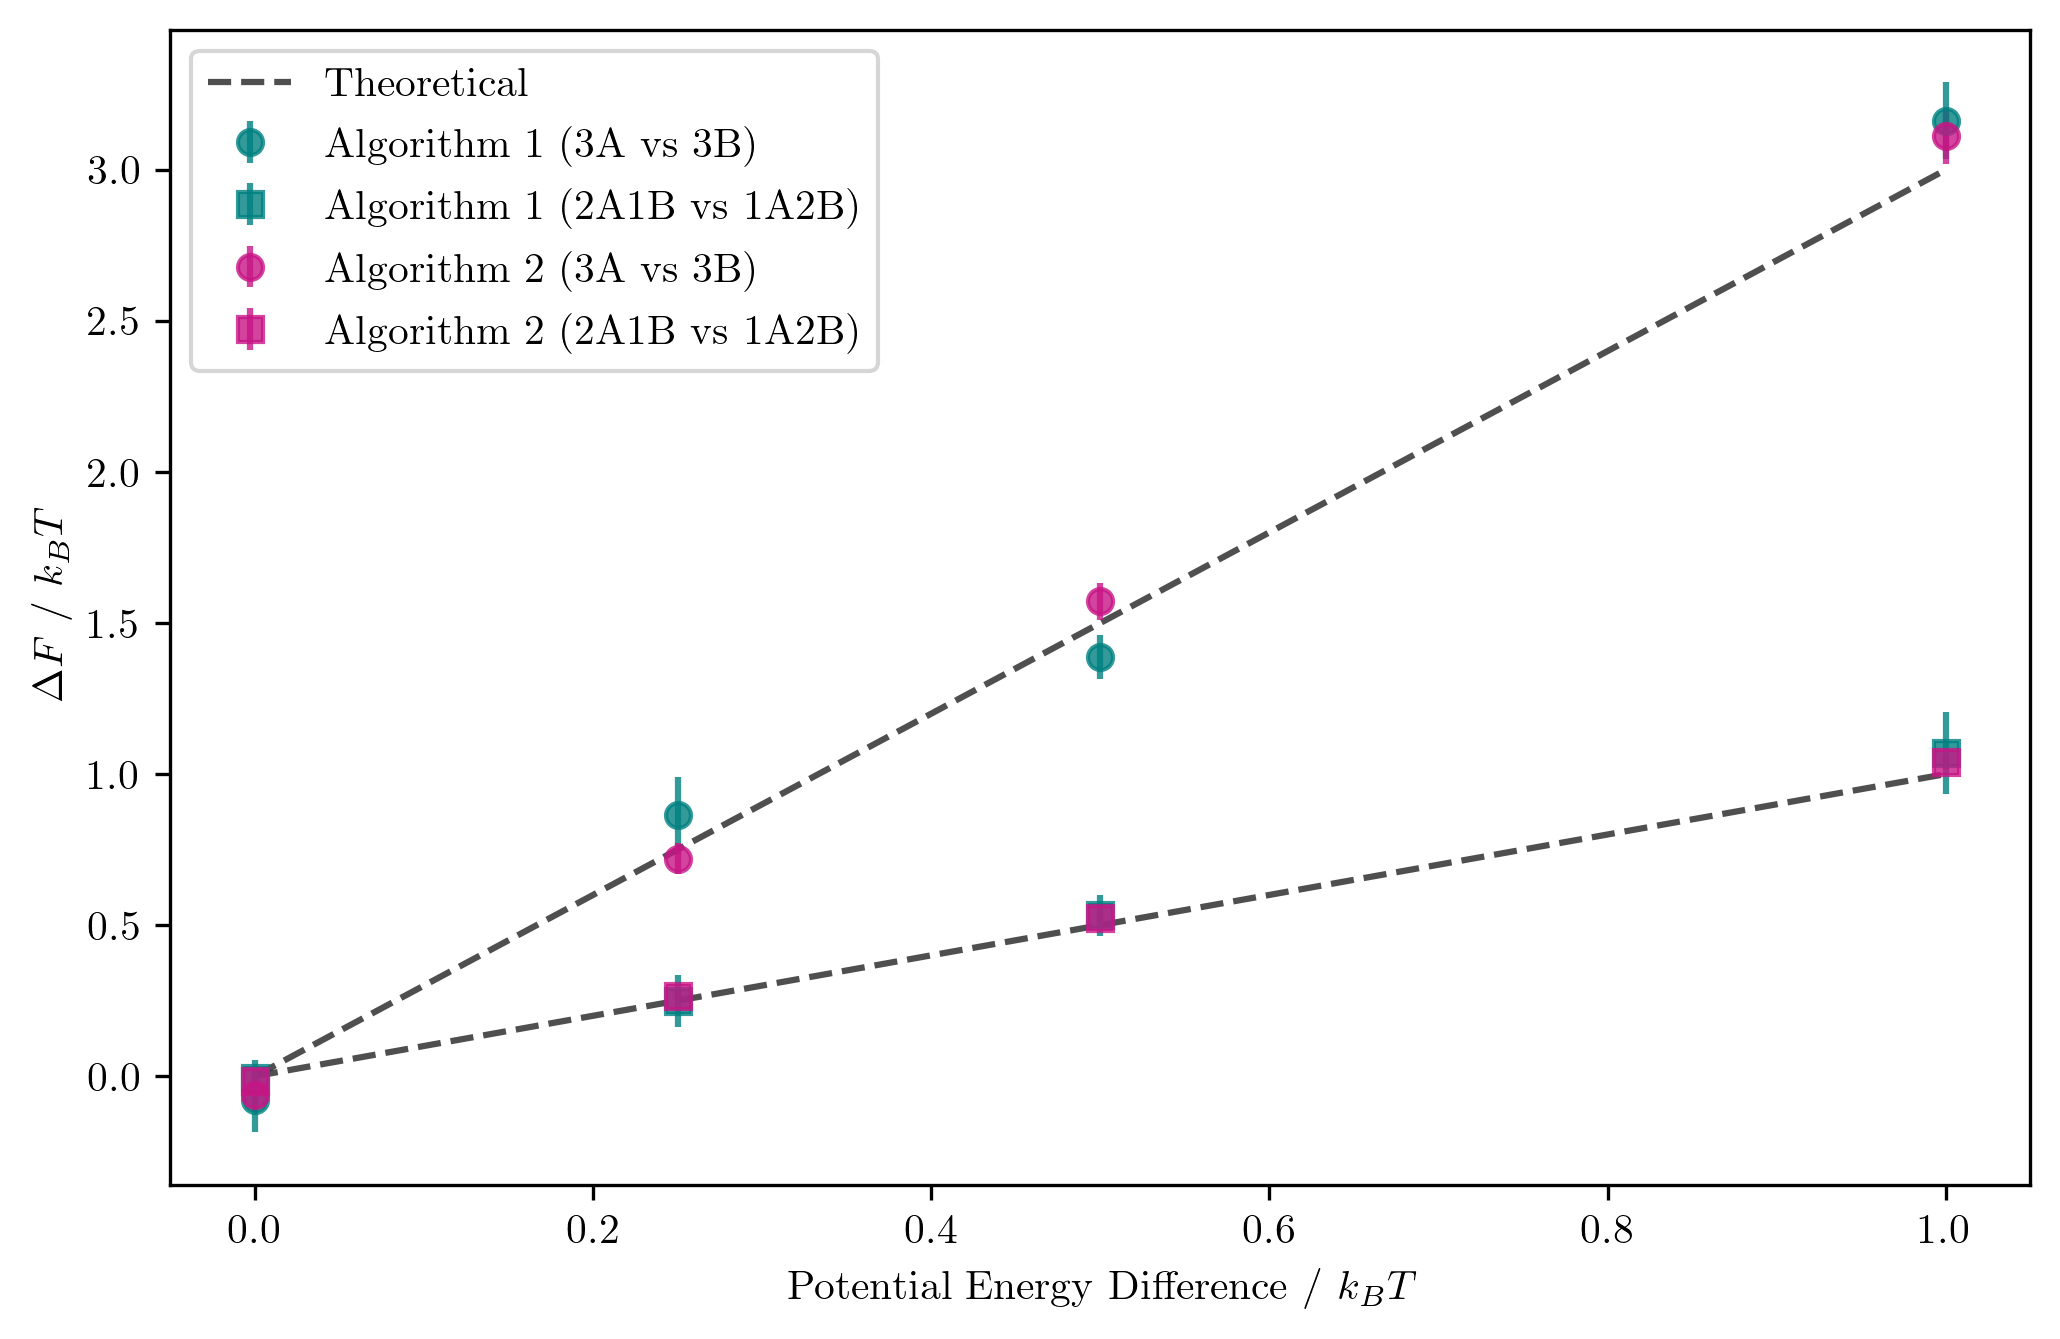

In [12]:
import matplotlib.pyplot as plt
sys.path.append("/home/n2401517d/my_workspace/HMC_NF")
from utils import get_icl_heatmap_cmap, classify_particles, set_icl_color_cycle, calculate_pair_correlation, plot_pair_correlation, plot_loss, plot_frequency_heatmap, generate_samples, calculate_pair_correlation, plot_pair_correlation, save_rdf_data, plot_acceptance_rate,plot_avg_free_energy, plot_well_statistics, plot_avg_x_coordinate,plot_multiple_avg_x_coordinates
set_icl_color_cycle()

def plot_free_energy_comparison(results, dV_vals):
    """
    Create a plot comparing free energy differences with theoretical values.
    
    Args:
        results (dict): Dictionary of results from analyze_all_free_energy_datasets
        dV_vals (list): List of dV values analyzed
    """
    # Extract data
    dV_x = np.array([float(dV) for dV in dV_vals])
    
    # Theoretical values
    theory_x = np.linspace(0, max(dV_x), 100)
    theory_wells = theory_x * 3  # For 3A vs 3B
    theory_mixed = theory_x * 1  # For 2A1B vs 1A2B
    
    # Create figure
    fig, ax = plt.subplots(figsize=(8, 5))
    
    # Plot theoretical lines
    ax.plot(theory_x, theory_wells, color="C11", linestyle="--", alpha=0.8, label='Theoretical')
    ax.plot(theory_x, theory_mixed, color="C11", linestyle="--", alpha=0.8)
    
    # Plot Algorithm 1 data
    if not all(np.isnan(results['algo1']['wells_means'])):
        ax.errorbar(dV_x, results['algo1']['wells_means'], yerr=results['algo1']['wells_sems'], 
                   fmt='o', color='C2', alpha=0.8, label='Algorithm 1 (3A vs 3B)')
    
    if not all(np.isnan(results['algo1']['mixed_means'])):
        ax.errorbar(dV_x, results['algo1']['mixed_means'], yerr=results['algo1']['mixed_sems'], 
                   fmt='s', color='C2', alpha=0.8, label='Algorithm 1 (2A1B vs 1A2B)')
    
    # Plot Algorithm 2 data
    if not all(np.isnan(results['algo2']['wells_means'])):
        ax.errorbar(dV_x, results['algo2']['wells_means'], yerr=results['algo2']['wells_sems'], 
                   fmt='o', color='C5', alpha=0.8, label='Algorithm 2 (3A vs 3B)')
    
    if not all(np.isnan(results['algo2']['mixed_means'])):
        ax.errorbar(dV_x, results['algo2']['mixed_means'], yerr=results['algo2']['mixed_sems'], 
                   fmt='s', color='C5', alpha=0.8, label='Algorithm 2 (2A1B vs 1A2B)')
    
    # Labels and styling
    ax.set_xlabel('Potential Energy Difference / $k_BT$')
    ax.set_ylabel('$\Delta F$ / $k_BT$')
    ax.legend(loc='best')
    
    # Save the plot
    output_dir = "/home/n2401517d/my_workspace/HMC_NF/analysis/"
    os.makedirs(output_dir, exist_ok=True)
    fig.savefig(f"{output_dir}/free_energy_comparison.png", dpi=300, bbox_inches='tight')
    fig.savefig(f"{output_dir}/free_energy_comparison.svg", bbox_inches='tight')
    plt.show()
    plt.close(fig)

plot_free_energy_comparison(results, dV_vals)